In [ ]:
# Create virtualenv
!python -m venv /content/myenv
!source /content/myenv/bin/activate

#Install exact versions
!pip install \
    fsspec==2025.3.0 \
    protobuf==5.26.1 \
    google-auth==2.38.0 \
    decorator==4.4.2 \
    google-cloud-storage==2.8.0

#install other packages
!pip install gcsfs datasets tensorflow

#Install additional required libraries
!pip install bert-score -q

Error: Command '['/content/myenv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: /content/myenv/bin/activate: No such file or directory
ERROR: Operation cancelled by user
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install required libraries
!pip install transformers datasets evaluate accelerate -q
!pip install rouge-score -q

#Import ALL necessary modules
from datasets import load_dataset
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import evaluate
import torch
import numpy as np

#Import additional modules
import matplotlib.pyplot as plt
from bert_score import score as bert_score



#Load and prepare dataset
import pandas as pd
from datasets import Dataset, DatasetDict

# Load each JSON file using pandas
train_df = pd.read_json('/content/drive/MyDrive/summary/train.json')
val_df = pd.read_json('/content/drive/MyDrive/summary/val.json')
test_df = pd.read_json('/content/drive/MyDrive/summary/test.json')

# Convert to Dataset
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df),
    'test': Dataset.from_pandas(test_df)
})

#Initialize tokenizer and model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

#Preprocess data with dynamic length handling
def preprocess_function(examples):
    inputs = [dialogue.replace('\r', '\n') for dialogue in examples["dialogue"]]
    model_inputs = tokenizer(
        inputs,
        max_length=512,  # Reduced from 1024 for speed
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"],
        max_length=64,  # Reduced from 128 for speed
        truncation=True,
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)

#Initialize dynamic padding collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding="longest"  # Dynamic padding
)

#Set up metrics
rouge = evaluate.load("rouge")

#Modified compute_metrics function with BLEU
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE
    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    # Compute BLEU
    bleu = evaluate.load("bleu")
    bleu_result = bleu.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels]
    )

    return {
        **{k: round(v * 100, 4) for k, v in rouge_result.items()},
        "bleu": round(bleu_result["bleu"] * 100, 4)
    }

#Configure optimized training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="bart-samsum",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,  # Increased batch size
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,  # Helps with memory
    weight_decay=0.01,
    save_strategy="epoch",
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    logging_steps=100,
    optim="adafactor",  # More memory-efficient optimizer
    report_to="none"
)

#Create trainer with dynamic padding
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator  # Using dynamic padding
)


Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

<ipython-input-7-b42342f77baa>:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Train
trainer.train()

#Evaluate
results = trainer.evaluate(tokenized_dataset["test"])
print(results)

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu
1,1.773000,1.571202,47.493600,24.223500,40.112700,40.061800,12.978300
2,1.605400,1.527714,47.783400,24.790400,40.584000,40.539700,12.907200
3,1.479500,1.505980,49.015000,25.762400,41.588100,41.583500,13.420400
4,1.374600,1.500513,48.966700,26.035500,41.576300,41.548300,14.034300
5,1.300400,1.499407,48.971200,25.800000,41.621500,41.597200,13.843000


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'eval_loss': 1.532461166381836, 'eval_rouge1': 47.5648, 'eval_rouge2': 24.1601, 'eval_rougeL': 40.4496, 'eval_rougeLsum': 40.4421, 'eval_bleu': 13.1641, 'eval_runtime': 49.807, 'eval_samples_per_second': 16.443, 'eval_steps_per_second': 2.068, 'epoch': 5.0}


In [ ]:
#save MODEL
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory where to save the model
save_dir = "/content/drive/MyDrive/bart_summarization_model"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the trained model and tokenizer
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Model and tokenizer saved to {save_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer saved to /content/drive/MyDrive/bart_summarization_model


In [ ]:
#BART MODEL SAVE

In [ ]:
from google.colab import drive
from transformers import BartTokenizer, BartForConditionalGeneration  # Changed to BART classes
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory where the model is saved
model_dir = "/content/drive/MyDrive/bart_summarization_model"  # Ensure this path is correct

# Load the tokenizer and model (using BART classes)
tokenizer = BartTokenizer.from_pretrained(model_dir)  # Fixed: Using BartTokenizer
model = BartForConditionalGeneration.from_pretrained(model_dir)  # Fixed: Using BartForConditionalGeneration

print("BART Model and tokenizer loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BART Model and tokenizer loaded successfully!


In [ ]:
# # downloadable model backup
# !zip -r /content/t5_model.zip /content/drive/MyDrive/bart_summarization_model
# from google.colab import files
# files.download("/content/bart_model.zip")

In [ ]:
#Generate predictions and compute BERTScore after training
# Generate test set predictions
test_results = trainer.evaluate(tokenized_dataset["test"])

# Get predictions and labels
predictions = trainer.predict(tokenized_dataset["test"])
preds = predictions.predictions
labels = predictions.label_ids

# Decode texts - handle None values properly
decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

# Filter out any None values that might still exist
decoded_preds = [pred for pred in decoded_preds if pred is not None]
decoded_labels = [label for label in decoded_labels if label is not None]

# Make sure we have matching lengths
min_length = min(len(decoded_preds), len(decoded_labels))
decoded_preds = decoded_preds[:min_length]
decoded_labels = decoded_labels[:min_length]

# Compute BERTScore
P, R, F1 = bert_score(decoded_preds, decoded_labels, lang="en")
bert_score_result = {
    "bert_score_precision": round(P.mean().item() * 100, 4),
    "bert_score_recall": round(R.mean().item() * 100, 4),
    "bert_score_f1": round(F1.mean().item() * 100, 4)
}

# Combine all results
final_results = {**test_results, **bert_score_result}
print("\nFinal Evaluation Results:")
for k, v in final_results.items():
    print(f"{k}: {v}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Final Evaluation Results:
eval_loss: 1.532461166381836
eval_rouge1: 47.5648
eval_rouge2: 24.1601
eval_rougeL: 40.4496
eval_rougeLsum: 40.4421
eval_bleu: 13.1641
eval_runtime: 65.0179
eval_samples_per_second: 12.597
eval_steps_per_second: 1.584
epoch: 5.0
bert_score_precision: 91.9288
bert_score_recall: 90.2968
bert_score_f1: 91.0871


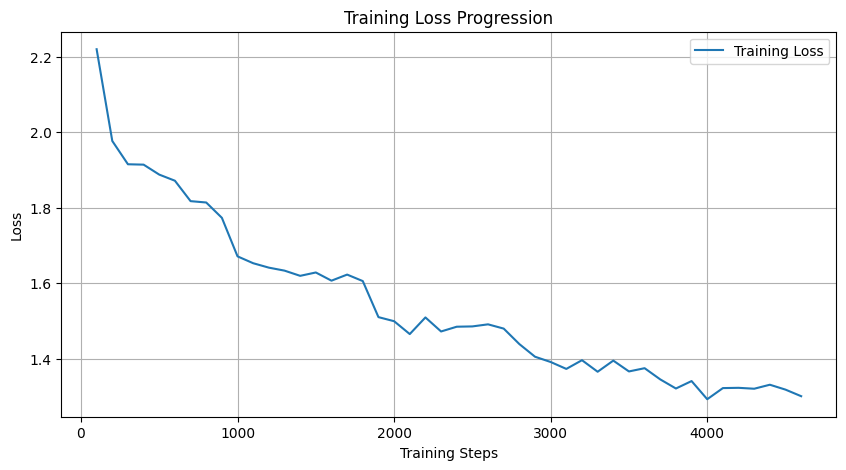

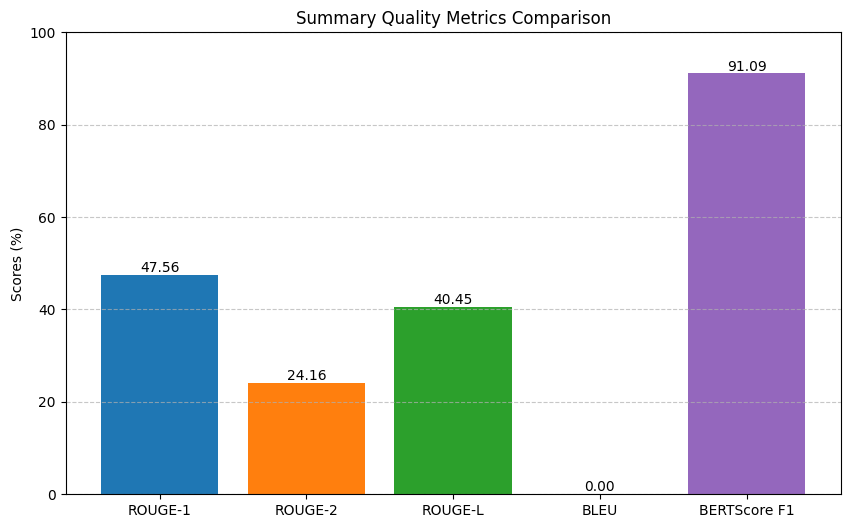

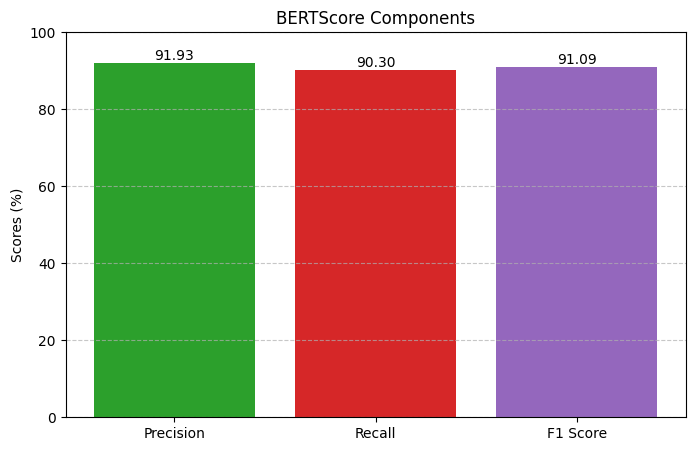

In [ ]:
#Visualization
# Plot training loss
plt.figure(figsize=(10, 5))
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
steps = [log['step'] for log in trainer.state.log_history if 'loss' in log]

plt.plot(steps, train_loss, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Progression')
plt.legend()
plt.grid(True)
plt.show()

# Plot metrics comparison - with error handling
metrics = {}
possible_rouge_keys = ['rouge1', 'rouge2', 'rougeL', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL']

# Find which ROUGE keys actually exist in results
rouge_keys_in_results = [key for key in possible_rouge_keys if key in final_results]

if rouge_keys_in_results:
    # Use the first matching key pattern found
    rouge_prefix = rouge_keys_in_results[0].replace('rouge1', '')  # Gets 'eval_' if present

    metrics.update({
        'ROUGE-1': final_results.get(f'{rouge_prefix}rouge1', 0),
        'ROUGE-2': final_results.get(f'{rouge_prefix}rouge2', 0),
        'ROUGE-L': final_results.get(f'{rouge_prefix}rougeL', 0),
    })

# Add other metrics that might exist
other_metrics = {
    'BLEU': final_results.get('bleu', 0),
    'BERTScore F1': final_results.get('bert_score_f1', 0)
}
metrics.update(other_metrics)

# Only plot if we have at least one metric
if metrics:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

    plt.ylabel('Scores (%)')
    plt.title('Summary Quality Metrics Comparison')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

    plt.show()
else:
    print("No metrics available for visualization")

# Plot BERTScore components if available
if all(key in final_results for key in ['bert_score_precision', 'bert_score_recall', 'bert_score_f1']):
    bert_components = {
        'Precision': final_results['bert_score_precision'],
        'Recall': final_results['bert_score_recall'],
        'F1 Score': final_results['bert_score_f1']
    }

    plt.figure(figsize=(8, 5))
    bars = plt.bar(bert_components.keys(), bert_components.values(), color=['#2ca02c', '#d62728', '#9467bd'])

    plt.ylabel('Scores (%)')
    plt.title('BERTScore Components')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

    plt.show()
else:
    print("BERTScore components not available for visualization")

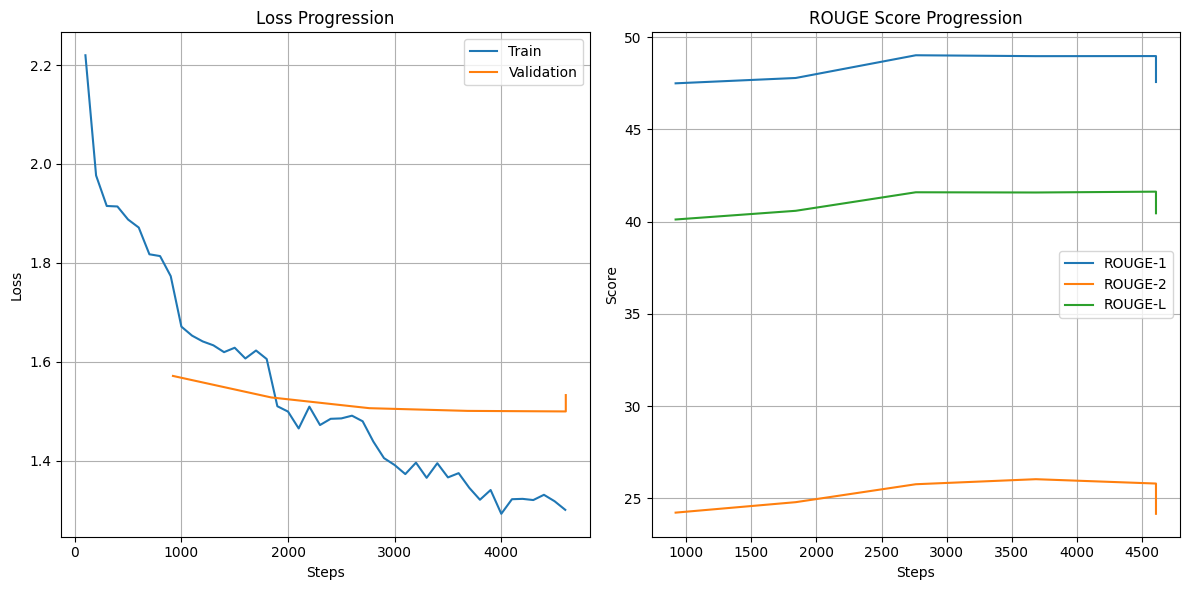

In [ ]:
#Combined Training & Validation Metrics
plt.figure(figsize=(12, 6))

# Extract metrics from log history
log_history = trainer.state.log_history
train_metrics = [x for x in log_history if 'loss' in x]
eval_metrics = [x for x in log_history if 'eval_loss' in x]

# Plot loss
plt.subplot(1, 2, 1)
plt.plot([x['step'] for x in train_metrics], [x['loss'] for x in train_metrics], label='Train')
plt.plot([x['step'] for x in eval_metrics], [x['eval_loss'] for x in eval_metrics], label='Validation')
plt.title('Loss Progression')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot ROUGE scores if available
if 'eval_rouge1' in eval_metrics[0]:
    plt.subplot(1, 2, 2)
    plt.plot([x['step'] for x in eval_metrics], [x['eval_rouge1'] for x in eval_metrics], label='ROUGE-1')
    plt.plot([x['step'] for x in eval_metrics], [x['eval_rouge2'] for x in eval_metrics], label='ROUGE-2')
    plt.plot([x['step'] for x in eval_metrics], [x['eval_rougeL'] for x in eval_metrics], label='ROUGE-L')
    plt.title('ROUGE Score Progression')
    plt.xlabel('Steps')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

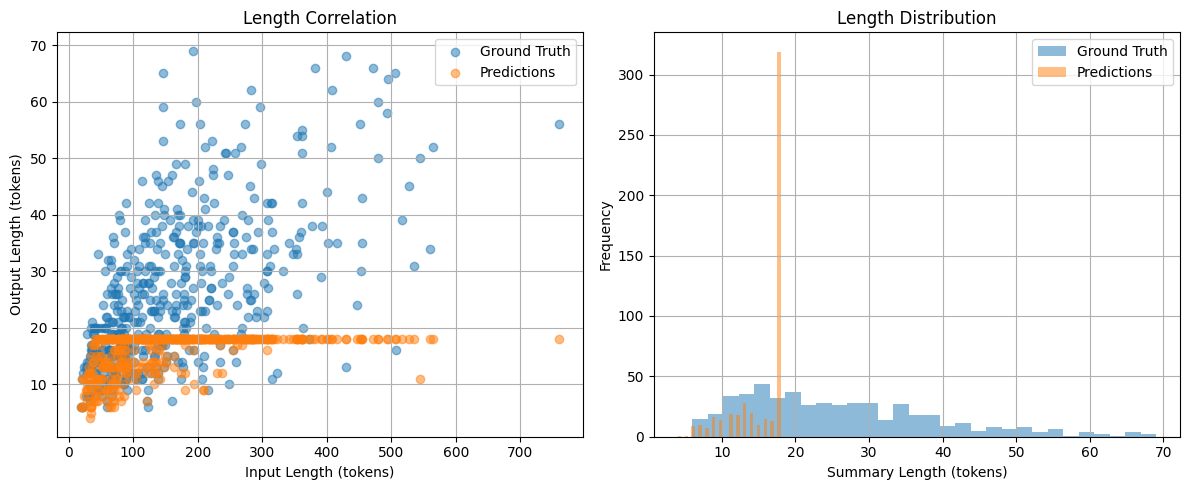

In [ ]:
#Input-Output Length Relationship
plt.figure(figsize=(12, 5))

# Calculate lengths
input_lengths = [len(tokenizer.tokenize(x)) for x in dataset['test']['dialogue'][:500]]
output_lengths = [len(tokenizer.tokenize(x)) for x in dataset['test']['summary'][:500]]
pred_lengths = [len(tokenizer.tokenize(x)) for x in decoded_preds[:500]]

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(input_lengths, output_lengths, alpha=0.5, label='Ground Truth')
plt.scatter(input_lengths, pred_lengths, alpha=0.5, label='Predictions')
plt.xlabel('Input Length (tokens)')
plt.ylabel('Output Length (tokens)')
plt.title('Length Correlation')
plt.legend()
plt.grid(True)

# Length distribution
plt.subplot(1, 2, 2)
plt.hist(output_lengths, bins=30, alpha=0.5, label='Ground Truth')
plt.hist(pred_lengths, bins=30, alpha=0.5, label='Predictions')
plt.xlabel('Summary Length (tokens)')
plt.ylabel('Frequency')
plt.title('Length Distribution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#Qualitative Examples Display
from IPython.display import HTML
import random

sample_indices = random.sample(range(len(decoded_preds)), 5)
examples = []
for idx in sample_indices:
    examples.append({
        "Input": dataset['test']['dialogue'][idx][:150] + "...",
        "Reference": decoded_labels[idx],
        "Prediction": decoded_preds[idx],
        "ROUGE-L": rouge.compute(
            predictions=[decoded_preds[idx]],
            references=[decoded_labels[idx]],
            use_stemmer=True)['rougeL']
    })

# Create HTML table
html = "<table><tr><th>Input</th><th>Reference</th><th>Prediction</th><th>ROUGE-L</th></tr>"
for ex in examples:
    html += f"""
    <tr>
        <td style='max-width:200px;word-wrap:break-word'>{ex['Input']}</td>
        <td style='max-width:200px;word-wrap:break-word'>{ex['Reference']}</td>
        <td style='max-width:200px;word-wrap:break-word'>{ex['Prediction']}</td>
        <td>{ex['ROUGE-L']*100:.1f}%</td>
    </tr>
    """
html += "</table>"
display(HTML(html))

Input,Reference,Prediction,ROUGE-L
"Ollie: Okay, Kelly! Ur up nxt! Kelly: Me? I don't wanna. Mickey: C'mon! Jessica: Yeah! What's yours? Kelly: Fine. It's a sculpture garden in Finnl...","Kelly is scared of sculpture garden figures in Finnland, she finds figure's faces morbid. For Ollie it's Nagoro village in Japan, it's creepy.","Ollie, Kelly, Mickey and Jessica are going to Nagoro village in Japan.",26.3%
"Charles: What are you up to this weekend? Camilla: Not much. Just some work and errands on Saturday, show Saturday night. Day of nothingness on Sundy...",Camilla has some errands to do on Saturday. Charles is visiting the German markets this weekend. They are talking about Christmas food and drinks.,Charles and Camilla are going to visit the German markets this weekend. They will have sausage,45.0%
"Abby: Have you talked to Miro? Dylan: No, not really, I've never had an opportunity Brandon: me neither, but he seems a nice guy Brenda: you met hi...",Miro speaks Albanian with his parents. His family left Albania illegally in 1990s.,Miro told Abby the story of his father coming from Albania to the US in the early,26.7%
Shaldona: WE ARE GONNA GET MARRIED ❤️❤️ Shaldona: Shaldona: This is our mobile inviation for our wedding. Shaldona: Invitation* Piper: H...,"Shaldona sends mobile invitations to her wedding, as she has no time to give them in person.",Shaldona sent Piper her wedding invitation.,26.1%
Emily: fancy a drink after work today? Kate: sure! Marta: Good idea! Marta: Where? When? Emily: Maybe in the Pub X at the central station at 5.30...,"Emily, Kate and Marta are going to the Pub X at the central station today for a drink.","Emily, Kate and Marta will meet for a drink at Pub X at the central station",58.8%
